### Load an image and pass it to a model

In [1]:
from skimage import io, img_as_float, img_as_ubyte
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from glob import glob

In [2]:
img = img_as_float(io.imread('dataset/DIC-HeLa/training/images/t000.tif'))
mask = img_as_float(io.imread('dataset/DIC-HeLa/training/masks/man_seg000.tif'))

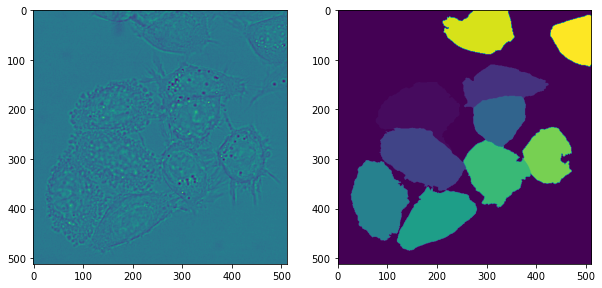

In [3]:
fix, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(mask)

In [4]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8, pretrained=False)

Using cache found in C:\Users\bli346/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [5]:
model.to('cuda')

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_run

In [6]:
input = torch.from_numpy( img )[None, None, :].float()
input = input.to('cuda')
output = model(input)

In [7]:
model.train()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # 0.0001

In [53]:
imgs = glob('dataset/DIC-HeLa/training/images/*.tif')
masks = glob('dataset/DIC-HeLa/training/masks/*.tif')
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = img_as_float(io.imread(img))
    mask = img_as_float(io.imread(mask))
    mask[mask>0] = 1
    input = torch.from_numpy( img )[None, None, :].float().cuda()
    target = torch.from_numpy( mask )[None, None, :].float().cuda()
    output = model(input)
    loss = loss_fn(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss, current = loss.item(), i
    print(f"loss: {loss:>7f}  [{current:>5d}/{len(imgs):>5d}]")

loss: 0.763469  [    0/   84]
loss: 0.770902  [    1/   84]
loss: 0.770299  [    2/   84]
loss: 0.768270  [    3/   84]
loss: 0.772750  [    4/   84]
loss: 0.761580  [    5/   84]
loss: 0.764499  [    6/   84]
loss: 0.762003  [    7/   84]
loss: 0.770681  [    8/   84]
loss: 0.779524  [    9/   84]
loss: 0.774453  [   10/   84]
loss: 0.767490  [   11/   84]
loss: 0.772008  [   12/   84]
loss: 0.768697  [   13/   84]
loss: 0.765935  [   14/   84]
loss: 0.759504  [   15/   84]
loss: 0.765001  [   16/   84]
loss: 0.762028  [   17/   84]
loss: 0.762045  [   18/   84]
loss: 0.755331  [   19/   84]
loss: 0.757708  [   20/   84]
loss: 0.750702  [   21/   84]
loss: 0.761207  [   22/   84]
loss: 0.749786  [   23/   84]
loss: 0.745053  [   24/   84]
loss: 0.742901  [   25/   84]
loss: 0.740549  [   26/   84]
loss: 0.739184  [   27/   84]
loss: 0.740303  [   28/   84]
loss: 0.739442  [   29/   84]
loss: 0.740430  [   30/   84]
loss: 0.743210  [   31/   84]
loss: 0.745903  [   32/   84]
loss: 0.75

### use dataloader

In [6]:
device = 'cuda'
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # N x 1 x H x W
            test_loss += loss_fn(pred, y).item()
            pred[pred>0.5] = 1
            pred[pred<=0.5] = 0
            correct += (pred == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size*(512**2)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

In [8]:
class ImageMaskPair(Dataset):
    def __init__(self, img_paths, mask_paths, transforms=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        if transforms is not None:
            self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = img_as_float(io.imread(self.img_paths[idx]))
        mask = img_as_float(io.imread(self.mask_paths[idx]))
        mask[mask>0] = 1
        # img = torch.from_numpy( img )[None, :].float() # C x H x W
        # mask = torch.from_numpy( mask )[None, :].float() # C x H x W
        img = self.transforms(img)
        mask = self.transforms(mask)
        return img, mask

In [14]:
pair_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

In [15]:
img_train_paths = glob('dataset/DIC-HeLa/training/images/*.tif')
mask_train_paths = glob('dataset/DIC-HeLa/training/masks/*.tif')
img_test_paths = glob('dataset/DIC-HeLa/testing/images/*.tif')
mask_test_paths = glob('dataset/DIC-HeLa/testing/masks/*.tif')

In [16]:
image_mask_train_pair = ImageMaskPair(img_train_paths, mask_train_paths, transforms=pair_transforms)
train_dataloader = DataLoader(image_mask_train_pair, batch_size=4, shuffle=True)
image_mask_test_pair = ImageMaskPair(img_test_paths, mask_test_paths, transforms=pair_transforms)
test_dataloader = DataLoader(image_mask_test_pair, batch_size=4, shuffle=True)

Feature batch shape: torch.Size([4, 1, 512, 512])
Labels batch shape: torch.Size([4, 1, 512, 512])


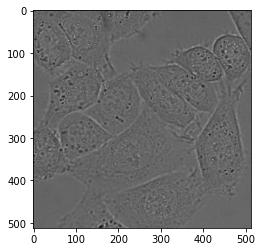

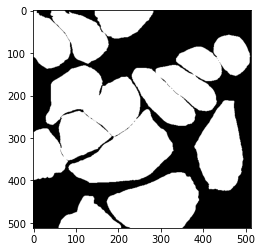

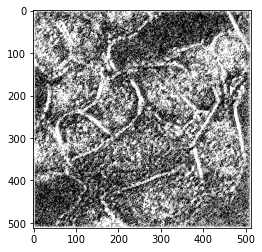

In [17]:
train_images, train_masks = next(iter(test_dataloader))
out_masks = model(train_images.cuda())
print(f"Feature batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_masks.size()}")
img = train_images[0].squeeze()
label = train_masks[0].squeeze()
out_masks[out_masks>0.5] = 1
out_masks[out_masks<=0.5] = 0
out = out_masks[0].detach().cpu().squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()
plt.imshow(out, cmap="gray")
plt.show()

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # 0.0001
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.742629  [    0/   84]
loss: 0.740377  [   40/   84]
loss: 0.725368  [   80/   84]
Test Error: 
 Accuracy: 46.8%, Avg loss: 0.703579 

Epoch 2
-------------------------------
loss: 0.755466  [    0/   84]
loss: 0.759623  [   40/   84]
loss: 0.723513  [   80/   84]
Test Error: 
 Accuracy: 47.2%, Avg loss: 0.702147 

Epoch 3
-------------------------------
loss: 0.727212  [    0/   84]
loss: 0.707685  [   40/   84]
loss: 0.735056  [   80/   84]
Test Error: 
 Accuracy: 51.9%, Avg loss: 0.701437 

Epoch 4
-------------------------------
loss: 0.736584  [    0/   84]
loss: 0.731692  [   40/   84]
loss: 0.697527  [   80/   84]
Test Error: 
 Accuracy: 56.2%, Avg loss: 0.701172 

Epoch 5
-------------------------------
loss: 0.754686  [    0/   84]
loss: 0.735087  [   40/   84]
loss: 0.749927  [   80/   84]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.700439 

Epoch 6
-------------------------------
loss: 0.733124  [    0/   84]
loss: 0.731871  [   

KeyboardInterrupt: 